In [197]:
# synpuff.ipynb content
import pandas as pd
pd.set_option("display.max_rows", None, "mode.chained_assignment", None)
from itertools import chain

import numpy as np
import datetime as dt

In [198]:
from dash import Dash, html, dcc, Input, Output, callback
import plotly.express as px
import plotly
import plotly.offline
import plotly.graph_objs as go

In [199]:
person = pd.read_csv('../../synpuff/person.csv')
condition_occurrence = pd.read_csv('../../synpuff/condition_occurrence.csv')
drug_exposure = pd.read_csv('../../synpuff/drug_exposure.csv')
concept = pd.read_csv('../../synpuff/concept.csv')
hierarchy = pd.read_csv('../../synpuff/hierarchy.csv')
props = pd.read_csv('../../synpuff/hemonc_component_properties.csv')

In [200]:
condition_occurrence.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id
0,61875376,497795,132797,2008-01-31,NaN,2008-02-07,NaN,38000200,NaN,142878.0,23882463,NaN,0389,44823969,NaN,NaN
1,137844436,1109737,133141,2008-12-12,NaN,2008-12-14,NaN,38000200,NaN,34304.0,53218870,NaN,1104,44822853,NaN,NaN
2,236827453,1906124,438699,2008-09-28,NaN,2008-10-06,NaN,38000200,NaN,83387.0,91427916,NaN,1540,44822870,NaN,NaN
3,116917366,940851,441829,2009-03-10,NaN,2009-03-17,NaN,38000200,NaN,323636.0,45136153,NaN,2760,44824089,NaN,NaN
4,171844758,1382957,437833,2009-05-24,NaN,2009-05-25,NaN,38000200,NaN,228426.0,66341079,NaN,2768,44834567,NaN,NaN


In [201]:
neoplasm_codes = [44832128,44834489,44834490,44819488,44826452,44825256]
condition_occurrence=condition_occurrence.loc[condition_occurrence['condition_source_concept_id'].isin(neoplasm_codes)]


'''Ivy's code'''
#rxnorm = props[props['vocabulary_id']=='RxNorm']
#list of valid drug categories from Ivy from RxNorm/HemOnc
sact=['Alkylating agent', 'Anti-CD38 antibody', 'Anti-CTLA-4 antibody', 'Anti-TACSTD2 antibody-drug conjugate', 'Anthracycline', 'Antiandrogen', 'Antifolate',
'Antimetabolite', 'Antitumor antibiotic', 'Anti-CD52 antibody', 'Anti-CD20 antibody', 'Anti-EGFR antibody', 'Anti-HER2 antibody', 'Anti-CD38 antibody', 'Anti-PD-1 antibody',
'Anti-PD-L1 antibody', 'Anti-RANKL antibody', 'Anti-SLAMF7 antibody','Anti-VEGF antibody', 'Aromatase inhibitor', 'Aromatase inhibitorsthird generation',
'Biosimilar', 'BRAF inhibitor', 'DNA methyltransferase inhibitor', 'Deoxycytidine analog', 'EGFR inhibitor', 'ERBB 2 inhibitor', 'Estrogen receptor inhibitor',
'Folic acid analog', 'Fluoropyrimidine', 'GnRH agonist', 'HDAC inhibitor', 'Human DNA synthesisinhibitor', 'Microtubule inhibitor', 'MTOR inhibitor',
'Nitrogen mustard', 'Nitrosourea', 'Neutral', 'PARP inhibitor', 'PARP1 inhibitor', 'PARP2 inhibitor', 'Phenothiazine', 'Platinum agent', 'Proteasome inhibitor',
'Purine analog', 'Pyrimidine analog', 'RANK ligand inhibitor', 'Selective estrogen receptor modulator', 'Somatostatin analog', 'T-cell activator',
'Targeted therapeutic', 'Taxane', 'Topoisomerase I inhibitor', 'Topoisomerase II inhibitor', 'Triazene', 'Vinca alkaloid', 'Xanthine oxidase inhibitor',
'WHO Essential Cancer Medicine']
#rxnorm = rxnorm[rxnorm['component_class_name'].isin(sact)]
props=props[props['component_class_name'].isin(sact)]
antican = props['concept_id_2']
drug_exposure=drug_exposure[drug_exposure['drug_concept_id'].isin(antican)]
#rxnorm['component_class_name'].value_counts()


In [202]:
concept_lookup = {c.concept_id: c.concept_name for c in concept.itertuples()}

In [203]:
def make_labels(df):
    for c in df.columns:
        if 'concept_id' in c:
            df[c.replace('_id', '_label')] = df[c].map(concept_lookup)
        if 'concept_id' in c or 'source' in c or len(df[df[c].notna()])==0:
            df = df.drop(c, axis=1)
    return df


In [204]:
person_labelled = make_labels(person)
condition_occurrence_labelled = make_labels(condition_occurrence)
drug_exposure_labelled = make_labels(drug_exposure)

In [205]:
'''Applying extra filters to drug df'''
drug_exposure_labelled['drug_exposure_year'] = pd.to_datetime(drug_exposure_labelled['drug_exposure_start_date'], format='%Y-%m-%d').dt.year
exclusions = ['dexamethasone']
drug_exposure_labelled=drug_exposure_labelled[~drug_exposure_labelled['drug_concept_label'].isin(exclusions)]

In [206]:
person.head()

,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_label
0,8527,38003564,247,NaN,NaN,A071B74AF0F454BB,1,NaN,1,NaN,1,NaN,1468935,8507,1920,1,1,NaN,White
1,8527,38003564,994,NaN,NaN,C30A427E6C8881FE,1,NaN,1,NaN,1,NaN,2299017,8507,1923,1,1,NaN,White
2,8527,38003564,197,NaN,NaN,A66EF141738B9A51,1,NaN,1,NaN,1,NaN,1238988,8507,1924,1,1,NaN,White
3,8527,38003564,2296,NaN,NaN,B8C8F3044B75A0C6,1,NaN,1,NaN,1,NaN,1712715,8507,1934,1,1,NaN,White
4,8527,38003564,84,NaN,NaN,BBAF91DA9F34F9E3,1,NaN,1,NaN,1,NaN,899595,8507,1941,1,1,NaN,White


In [207]:
#neoplasm_concepts = concept.loc[concept['concept_code'].isin['174.0','174.6','174.8','175.0','175.9']]
#neoplasm_concepts

In [208]:
condition_occurrence_labelled.head()

,condition_occurrence_id,person_id,condition_start_date,condition_end_date,provider_id,visit_occurrence_id,condition_concept_label,condition_type_concept_label,condition_source_concept_label,condition_status_concept_label
157,210512628,1694338,2008-09-22,2008-09-22,151287.0,81272533,Malignant neoplasm of nipple and areola of fem...,Outpatient header - 1st position,Malignant neoplasm of nipple and areola of fem...,NaN
158,10158522,81751,2009-03-22,2009-03-22,258649.0,3923058,Malignant neoplasm of nipple and areola of fem...,Outpatient header - 1st position,Malignant neoplasm of nipple and areola of fem...,NaN
159,11359134,91329,2008-09-19,2008-09-19,164692.0,4385273,Malignant neoplasm of nipple and areola of fem...,Outpatient header - 1st position,Malignant neoplasm of nipple and areola of fem...,NaN
160,251553998,2024310,2009-07-29,2009-08-03,140597.0,97112208,Malignant neoplasm of axillary tail of female ...,Outpatient header - 1st position,Malignant neoplasm of axillary tail of female ...,NaN
266,250625743,2016747,2008-11-28,2008-11-28,378143.0,96753274,Neoplasm of uncertain behavior of breast,Outpatient header - 1st position,Neoplasm of uncertain behavior of breast,NaN


In [209]:
drug_exposure_labelled['drug_concept_label'].value_counts()

drug_concept_label
epoetin alfa          1845
cyclophosphamide       311
methylprednisolone     190
filgrastim             106
paclitaxel              91
doxorubicin             80
leuprolide              51
azacitidine             38
triptorelin             16
hydrocortisone          10
octreotide               8
methotrexate             7
Name: count, dtype: int64

In [210]:
drug_exposure_labelled.head()

,provider_id,visit_occurrence_id,drug_exposure_id,person_id,drug_exposure_start_date,drug_exposure_end_date,drug_type_concept_label,route_concept_label,drug_source_concept_label,drug_concept_label,drug_exposure_year
4,499713.0,69401622.0,78375973,1446685,2010-07-31,2010-08-30,Prescription dispensed in pharmacy,NaN,"Injection, azacitidine, 1 mg",azacitidine,2010
11,5123.0,82099224.0,92717626,1711440,2010-08-04,2010-09-03,Prescription dispensed in pharmacy,NaN,"Injection, methylprednisolone acetate, 20 mg",methylprednisolone,2010
13,97458.0,102174609.0,115350812,2129846,2008-06-28,2008-07-28,Prescription dispensed in pharmacy,NaN,"Injection, epoetin alfa, 100 units (for esrd o...",epoetin alfa,2008
26,2315.0,1703243.0,1894368,35153,2010-08-14,2010-09-13,Prescription dispensed in pharmacy,NaN,"Injection, epoetin alfa, 100 units (for esrd o...",epoetin alfa,2010
29,31954.0,25316689.0,28594997,527868,2010-08-16,2010-09-15,Prescription dispensed in pharmacy,NaN,"Injection, epoetin alfa, 100 units (for esrd o...",epoetin alfa,2010


In [211]:
drug_exposure_labelled['drug_exposure_start_date'].min()

'2007-12-21'

In [212]:
'''Data Linkage'''
person_labelled_small= person_labelled.loc[:,['person_id', 'year_of_birth', 'gender_concept_label']]
drug_persons = pd.merge(drug_exposure_labelled, person_labelled_small, on='person_id', how='left')
drug_persons['age_at_treatment'] = drug_persons['drug_exposure_year'] - drug_persons['year_of_birth']
#condition linkage
condition_labelled_small= condition_occurrence_labelled.loc[:,['person_id', 'condition_concept_label']]
condition_labelled_small['occ_number'] = 'cond_' + (condition_labelled_small.groupby('person_id').cumcount()).astype(str) 
cond_pivot = condition_labelled_small.pivot(index='person_id', columns='occ_number', values='condition_concept_label').reset_index()
drug_persons = pd.merge(drug_persons, cond_pivot, on='person_id', how='left')

In [213]:
drug_persons.head()

,provider_id,visit_occurrence_id,drug_exposure_id,person_id,drug_exposure_start_date,drug_exposure_end_date,drug_type_concept_label,route_concept_label,drug_source_concept_label,drug_concept_label,drug_exposure_year,year_of_birth,gender_concept_label,age_at_treatment,cond_0,cond_1,cond_2,cond_3
0,499713.0,69401622.0,78375973,1446685,2010-07-31,2010-08-30,Prescription dispensed in pharmacy,NaN,"Injection, azacitidine, 1 mg",azacitidine,2010,1921,MALE,89,NaN,NaN,NaN,NaN
1,5123.0,82099224.0,92717626,1711440,2010-08-04,2010-09-03,Prescription dispensed in pharmacy,NaN,"Injection, methylprednisolone acetate, 20 mg",methylprednisolone,2010,1935,FEMALE,75,Malignant neoplasm of nipple and areola of fem...,NaN,NaN,NaN
2,97458.0,102174609.0,115350812,2129846,2008-06-28,2008-07-28,Prescription dispensed in pharmacy,NaN,"Injection, epoetin alfa, 100 units (for esrd o...",epoetin alfa,2008,1931,FEMALE,77,NaN,NaN,NaN,NaN
3,2315.0,1703243.0,1894368,35153,2010-08-14,2010-09-13,Prescription dispensed in pharmacy,NaN,"Injection, epoetin alfa, 100 units (for esrd o...",epoetin alfa,2010,1926,MALE,84,NaN,NaN,NaN,NaN
4,31954.0,25316689.0,28594997,527868,2010-08-16,2010-09-15,Prescription dispensed in pharmacy,NaN,"Injection, epoetin alfa, 100 units (for esrd o...",epoetin alfa,2010,1949,MALE,61,NaN,NaN,NaN,NaN


<Axes: >

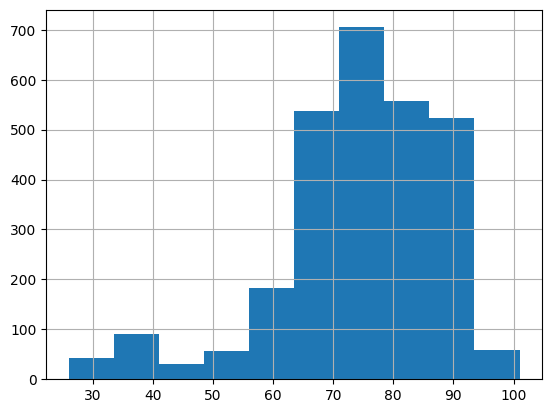

In [214]:
drug_persons['age_at_treatment'].hist()

In [215]:
drug_persons['age_at_treatment'].min()

26

In [216]:
drug_persons['age_at_treatment'].max()

101

In [217]:
#reduce DF down to relevant variables for the visualization
small = drug_persons[['person_id', 'drug_exposure_start_date', 'drug_concept_label', 'drug_exposure_year', 'gender_concept_label', 'age_at_treatment', 'cond_0', 'cond_1', 'cond_2', 'cond_3']]
#small = pd.merge(small, cond_pivot, on='person_id', how='left')
#small = small.dropna()
small = small.drop_duplicates()
small_sorted = small.sort_values('drug_concept_label')
#small['drug_concept_label'] = small_sorted.groupby(['person_id', 'drug_exposure_start_date'])['drug_concept_label'].transform(lambda x : ' & '.join(x))
#small.head()
small_nodup = small_sorted.drop_duplicates()
#small_nodup['drug_concept_label']=small_nodup['drug_concept_label'].str.replace('& ', '&<br>')

In [218]:
# add new variable for every new drug administration per person
readministrations = pd.Series(np.zeros(len(small_nodup),dtype=int),index=small_nodup.index)

In [219]:
# Loop through all unique ids                                                                                                                                                                                      
all_id = small_nodup['person_id'].unique()
id_administrations = {}
for pid in all_id:
    # These are all the times a patient with a given ID has had surgery                                                                                                                                            
    patient = small_nodup.loc[small_nodup['person_id']==pid]
    administrations_sorted = pd.to_datetime(patient['drug_exposure_start_date'], format='%Y-%m-%d').sort_values()

# This checks if the previous surgery was longer than 180 days ago                                                                                                                                              
    frequency = administrations_sorted.diff()<dt.timedelta(days=6000)

    # Compute the readmission                                                                                                                                                                                      
    n_administrations = [0]
    for v in frequency.values[1:]:
       n_administrations.append((n_administrations[-1]+1)*v)

    # Add these value to the time series                                                                                                                                                                           
    readministrations.loc[administrations_sorted.index] = n_administrations

small_nodup['readministration'] = readministrations
#small_nodup['drug_concept_label'] = small_nodup['drug_concept_label'] + (small_nodup['readministration'].apply(lambda x: x*' '))

In [220]:
small_nodup.head()

,person_id,drug_exposure_start_date,drug_concept_label,drug_exposure_year,gender_concept_label,age_at_treatment,cond_0,cond_1,cond_2,cond_3,readministration
0,1446685,2010-07-31,azacitidine,2010,MALE,89,NaN,NaN,NaN,NaN,0
2656,1695119,2009-06-11,azacitidine,2009,FEMALE,79,NaN,NaN,NaN,NaN,1
731,1414467,2010-01-15,azacitidine,2010,FEMALE,90,Carcinoma in situ of breast,NaN,NaN,NaN,0
1283,87256,2009-07-13,azacitidine,2009,MALE,66,NaN,NaN,NaN,NaN,0
1303,883237,2009-01-20,azacitidine,2009,FEMALE,66,NaN,NaN,NaN,NaN,0


In [221]:
display(small_nodup['cond_0'].value_counts())
display(small_nodup['cond_1'].value_counts())
display(small_nodup['cond_2'].value_counts())
display(small_nodup['cond_3'].value_counts())

cond_0
Carcinoma in situ of breast                                 52
Malignant neoplasm of axillary tail of female breast        47
Malignant neoplasm of nipple and areola of female breast    37
Neoplasm of breast                                           6
Neoplasm of uncertain behavior of breast                     6
Name: count, dtype: int64

cond_1
Carcinoma in situ of breast                                 10
Malignant neoplasm of nipple and areola of female breast     7
Malignant neoplasm of axillary tail of female breast         7
Neoplasm of uncertain behavior of breast                     1
Name: count, dtype: int64

cond_2
Malignant neoplasm of nipple and areola of female breast    6
Carcinoma in situ of breast                                 2
Name: count, dtype: int64

cond_3
Carcinoma in situ of breast    2
Name: count, dtype: int64

In [222]:
#pivot the DF from long to wide
pivoted = small_nodup.pivot(index='person_id', columns='readministration', values='drug_concept_label').reset_index()
# add the prefix 'drug' to every instance
prefixed = pivoted.add_prefix('drug')
#remove the word 'drug' from other variables
df = prefixed.rename(columns={"drugperson_id": "person_id", "readministration":"index"})

In [223]:
df.head()

readministration,person_id,drug0,drug1,drug2,drug3,drug4,drug5,drug6,drug7,drug8,...,drug15,drug16,drug17,drug18,drug19,drug20,drug21,drug22,drug23,drug24
0,1319,epoetin alfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5090,epoetin alfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8560,epoetin alfa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14706,paclitaxel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15157,cyclophosphamide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
df['drug3'].value_counts()

drug3
                      910
epoetin alfa           40
methylprednisolone      3
filgrastim              1
paclitaxel              1
Name: count, dtype: int64

In [225]:
#add a value of 1 to all data points for sums in the visualization
df["value"] = 1
#fill all empty cells with "N/A"
df = df.fillna(" ")

In [226]:
df.head()

readministration,person_id,drug0,drug1,drug2,drug3,drug4,drug5,drug6,drug7,drug8,...,drug16,drug17,drug18,drug19,drug20,drug21,drug22,drug23,drug24,value
0,1319,epoetin alfa,,,,,,,,,...,,,,,,,,,,1
1,5090,epoetin alfa,,,,,,,,,...,,,,,,,,,,1
2,8560,epoetin alfa,,,,,,,,,...,,,,,,,,,,1
3,14706,paclitaxel,,,,,,,,,...,,,,,,,,,,1
4,15157,cyclophosphamide,,,,,,,,,...,,,,,,,,,,1


In [227]:
fig = px.sunburst(df, path=[px.Constant('All'),'drug0', 'drug1', 'drug2', 'drug3', 'drug4', 'drug5'], values='value', color='drug0', width=600, height=600)
#fig.update_layout(hovermode=False)
#set marker colors whose labels are " " to transparent
marker_colors=list(fig.data[0].marker['colors'])
marker_labels=list(fig.data[0]['labels'])
new_marker_colors=["rgba(0,0,0,0)" if label==" " else color for (color, label) in zip(marker_colors, marker_labels)]
marker_colors=new_marker_colors
fig.data[0].marker['colors'] = marker_colors
fig.show()